# Final Term - Amazon Reviews

## Datasets:
Original dataset: 
https://www.kaggle.com/adityapatil673/critical-assessment-amazon-reviews-on-kindle/data

In [57]:
# dependencies
import pandas as pd
import nltk
import numpy as np
import io
import requests
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import word_tokenize
from nltk.corpus import stopwords
# from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_selection import chi2
from string import punctuation
from nltk import PorterStemmer
import copy 
import re, math
from sklearn.model_selection import train_test_split
from nltk import WordNetLemmatizer
from nltk import bigrams
from nltk.util import ngrams
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from gensim.models.ldamodel import LdaModel
from gensim.models import Doc2Vec, Word2Vec
from gensim.corpora import Dictionary
import pickle
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/yuxu/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /Users/yuxu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/yuxu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/yuxu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Import data and generate data table with summary statistics

In [147]:
df = pd.read_csv('Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv')

In [149]:
len(df)

5000

In [153]:
df_no_kindle = df[df.name.str.contains("Kindle|kindle")==False]

In [155]:
df_no_kindle.name.value_counts()

Amazon Echo Show Alexa-enabled Bluetooth Speaker with 7" Screen                                     845
All-New Fire HD 8 Tablet, 8" HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta            797
Amazon - Echo Plus w/ Built-In Hub - Silver                                                         590
Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Blue Kid-Proof Case                              561
Fire Tablet, 7 Display, Wi-Fi, 16 GB - Includes Special Offers, Black                               371
Amazon Tap - Alexa-Enabled Portable Bluetooth Speaker                                               225
Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Green Kid-Proof Case                             217
Fire HD 10 Tablet, 10.1 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Silver Aluminum         106
Fire Tablet with Alexa, 7" Display, 16 GB, Magenta - with Special Offers                            101
All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 32 GB - Includes 

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 24 columns):
id                     5000 non-null object
dateAdded              5000 non-null object
dateUpdated            5000 non-null object
name                   5000 non-null object
asins                  5000 non-null object
brand                  5000 non-null object
categories             5000 non-null object
primaryCategories      5000 non-null object
imageURLs              5000 non-null object
keys                   5000 non-null object
manufacturer           5000 non-null object
manufacturerNumber     5000 non-null object
reviews.date           5000 non-null object
reviews.dateAdded      1052 non-null object
reviews.dateSeen       5000 non-null object
reviews.doRecommend    5000 non-null bool
reviews.id             29 non-null float64
reviews.numHelpful     5000 non-null int64
reviews.rating         5000 non-null int64
reviews.sourceURLs     5000 non-null object
reviews.text      

In [4]:
for col in df.columns:
    print(f'{col} : {df[col].nunique()}')

id : 24
dateAdded : 20
dateUpdated : 17
name : 23
asins : 24
brand : 1
categories : 23
primaryCategories : 4
imageURLs : 24
keys : 24
manufacturer : 1
manufacturerNumber : 24
reviews.date : 679
reviews.dateAdded : 381
reviews.dateSeen : 417
reviews.doRecommend : 2
reviews.id : 26
reviews.numHelpful : 29
reviews.rating : 5
reviews.sourceURLs : 2827
reviews.text : 4385
reviews.title : 3124
reviews.username : 3815
sourceURLs : 24


In [5]:
df.drop(['asins','reviews.id','dateUpdated','dateUpdated', 'primaryCategories', 'manufacturerNumber','reviews.dateAdded','reviews.id','brand','imageURLs','keys','reviews.sourceURLs','sourceURLs'], axis=1, inplace=True)

In [6]:
df['reviews.doRecommend'].value_counts()

True     4765
False     235
Name: reviews.doRecommend, dtype: int64

In [7]:
df['reviews.rating'].value_counts()

5    3478
4    1208
3     197
1      63
2      54
Name: reviews.rating, dtype: int64

## Data is heavily skewed toward rating >3 and recommendation == True. Need to enrich with data that have lower rating or recommendation == False

In [8]:
df_large = pd.read_csv('1429_1.csv')

/anaconda3/envs/nlp_venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (1,10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [159]:
df_large_no_kindle = df_large[df_large.name.str.contains("Kindle|kindle")==False]

In [161]:
df_large_no_kindle.name.value_counts()

Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes Special Offers, Magenta                                                                                                                  10966
Echo (White),,,\r\nEcho (White),,,                                                                                                                                                       3309
All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta                                                                                                  2814
Amazon Fire Tv,,,\r\nAmazon Fire Tv,,,                                                                                                                                                   2527
Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Green Kid-Proof Case                                                                                                                  1685
Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes Spe

In [9]:
df_large['reviews.doRecommend'].value_counts()

True     32682
False     1384
Name: reviews.doRecommend, dtype: int64

In [10]:
df_large['reviews.rating'].value_counts()

5.0    23775
4.0     8541
3.0     1499
1.0      410
2.0      402
Name: reviews.rating, dtype: int64

In [11]:
# enrich original 5000 review data with large data that have recommendation == False or rating <=3
low_rated_data = df_large[(df_large['reviews.rating']<=3) | (df_large['reviews.doRecommend'] == False)]

In [12]:
columns = ['id', 'name', 'categories', 'manufacturer', 'reviews.date',
       'reviews.dateSeen', 'reviews.doRecommend', 'reviews.numHelpful',
       'reviews.rating', 'reviews.text', 'reviews.title', 'reviews.username']
df = pd.concat([df[columns], low_rated_data[columns]],axis=0)

In [13]:
df['reviews.doRecommend'].value_counts()

True     5786
False    1619
Name: reviews.doRecommend, dtype: int64

In [14]:
df['reviews.doRecommend'].replace({False: 0, True:1}, inplace=True)
df['reviews.doRecommend'].fillna(0, inplace=True)

In [15]:
df['reviews.rating'].value_counts()

5.0    3541
3.0    1696
4.0    1342
1.0     473
2.0     456
Name: reviews.rating, dtype: int64

In [16]:
# convert rating >3 to 1 and rating <=3 to 0
df.loc[df['reviews.rating']>3,'label'] = 1
df.loc[df['reviews.rating']<=3,'label'] = 0

In [17]:
df.label.value_counts()

1.0    4883
0.0    2625
Name: label, dtype: int64

In [18]:
df.head()

,id,name,categories,manufacturer,reviews.date,reviews.dateSeen,reviews.doRecommend,reviews.numHelpful,reviews.rating,reviews.text,reviews.title,reviews.username,label
0,AVqVGZNvQMlgsOJE6eUY,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...","Computers,Electronics Features,Tablets,Electro...",Amazon,2017-09-03T00:00:00.000Z,"2018-05-27T00:00:00Z,2017-09-18T00:00:00Z,2017...",0.0,0.0,3.0,I thought it would be as big as small paper bu...,Too small,llyyue,0.0
1,AVqVGZNvQMlgsOJE6eUY,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...","Computers,Electronics Features,Tablets,Electro...",Amazon,2017-06-06T00:00:00.000Z,"2018-05-27T00:00:00Z,2017-07-07T00:00:00Z,2017...",1.0,0.0,5.0,This kindle is light and easy to use especiall...,Great light reader. Easy to use at the beach,Charmi,1.0
2,AVqVGZNvQMlgsOJE6eUY,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...","Computers,Electronics Features,Tablets,Electro...",Amazon,2018-04-20T00:00:00.000Z,2018-05-27T00:00:00Z,1.0,0.0,4.0,Didnt know how much i'd use a kindle so went f...,Great for the price,johnnyjojojo,1.0
3,AVqVGZNvQMlgsOJE6eUY,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...","Computers,Electronics Features,Tablets,Electro...",Amazon,2017-11-02T17:33:31.000Z,2018-10-09T00:00:00Z,1.0,3.0,5.0,I am 100 happy with my purchase. I caught it o...,A Great Buy,Kdperry,1.0
4,AVqVGZNvQMlgsOJE6eUY,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...","Computers,Electronics Features,Tablets,Electro...",Amazon,2018-04-24T00:00:00.000Z,2018-05-27T00:00:00Z,1.0,0.0,5.0,Solid entry level Kindle. Great for kids. Gift...,Solid entry-level Kindle. Great for kids,Johnnyblack,1.0


# Check whether review is biased to spam reviewers

In [19]:
user_reviews = df['reviews.username'].value_counts()
bulk_reviewers = user_reviews[user_reviews>=10]
print('% of reviewers with >=10 reviews: {:02f}%'.format(len(bulk_reviewers)*100/len(user_reviews)))
print('% of reviews posted by bulk reviewers: {:02f}%'.format(sum(bulk_reviewers)*100/sum(user_reviews)))

% of reviewers with >=10 reviews: 0.348008%
% of reviews posted by bulk reviewers: 3.915823%


In [20]:
df['bulk']= df['reviews.username'].apply(lambda x : 1 if x in bulk_reviewers.index else 0)
#gives us the category whether a rating is bulk or not
from matplotlib import pyplot
print(df['reviews.rating'].hist(by=df.bulk))
print(df[df.bulk==1]['reviews.rating'].describe())
print(df[df.bulk==0]['reviews.rating'].describe())

count    294.000000
mean       4.142857
std        1.108453
min        1.000000
25%        3.000000
50%        5.000000
75%        5.000000
max        5.000000
Name: reviews.rating, dtype: float64
count    7214.000000
mean        3.926809
std         1.230046
min         1.000000
25%         3.000000
50%         4.000000
75%         5.000000
max         5.000000
Name: reviews.rating, dtype: float64


## Not too much rating differences between bulk and single reviewers. Likely those bulk reviewers were just frequent shopper and vocal reviewers than spammers.

# Start text distillation

In [21]:
# concatenate review text with review title due to:
# 1. we're not intended to calculate similarities between text and title
# 2. many titles are very short or nan
df['comment'] = df['reviews.text'].astype(str) + ' ' + df['reviews.title'].astype(str)

### Get raw sentiment score magnifier from counting exlamation marks and full cap words

In [22]:
def get_cap_and_exclamation_score(line):
    # 1+ len is to make sure the value is at least 1, for later use to multiply with other factors.
    return 1+len(re.findall(r'!{2,}', line)) + len(re.findall(r'[A-Z]{2,}', line))

df['strong_sentiment'] = df['comment'].apply(get_cap_and_exclamation_score)

In [23]:
df['strong_sentiment'].value_counts()

1     6296
2      745
3      242
4       94
5       36
6       26
7       17
9        7
10       6
8        5
13       5
14       4
15       3
18       2
11       2
28       2
35       2
17       2
12       1
32       1
44       1
16       1
83       1
21       1
25       1
45       1
57       1
38       1
23       1
29       1
Name: strong_sentiment, dtype: int64

### Get strong negative sentiment scores from a list of english bad words

In [69]:
bad_words = {key:1 for key in list(pd.read_csv('full-list-of-bad-words_csv-file_2018_07_30.csv',sep=';', header=None)[0])}

In [75]:
cachedStopWords = set(stopwords.words('english') + list(punctuation))

def get_bad_word(text):
    words = map(lambda word: word.lower(), word_tokenize(text))
    words = [word for word in words if word not in cachedStopWords]
    return len([word for word in words if word in bad_words])/len(words)*1000

df['strong_bad_senti'] = df['comment'].astype('U').apply(get_bad_word)

In [24]:
def tokenize(text):
    min_length = 3
    # tokenize
    # convert to lower case
    words = map(lambda word: word.lower(), word_tokenize(text))
    # remove stop words and punctuation
    words = [word for word in words if word not in cachedStopWords]
    # steming
    tokens = list(map(lambda token: PorterStemmer().stem(token), words))
    # lemmatize
    lemmas = [WordNetLemmatizer().lemmatize(word) for word in tokens]
    # only focus on alphabetic words
    p = re.compile('[a-zA-Z]+')
    
    filtered_lemmas = list(filter(lambda lemma: p.match(lemma) and len(lemma) >= min_length, lemmas))
    return filtered_lemmas

In [25]:
df['comment_clean']=df['comment'].astype('U').apply(tokenize)

# LDA for topic selection

In [26]:
dictionary = Dictionary(df['comment_clean'])

In [27]:
def get_topics(tokenized_words):
    new_doc_bow = [dictionary.doc2bow(tokenized_words)]
    model_ = LdaModel(new_doc_bow, num_topics=1, id2word=dictionary, passes=10)
    return [topic.replace('"','') for topic in re.findall(r'"\w+"', list(*model_.print_topics(num_words=10))[1])]

In [28]:
df['topics']=df['comment_clean'].apply(get_topics)

In [29]:
df['topics'].apply(len).value_counts()

10    5773
9     1549
8      162
7       18
6        5
5        1
Name: topics, dtype: int64

# Sentiment analysis

In [30]:
sid = SentimentIntensityAnalyzer()
def sentiment_analyzer(topics):
    score = sid.polarity_scores(" ".join(topics))
    return pd.Series(score)

df[['cmt_neg','cmt_neu','cmt_pos','cmt_cmpd' ] ]= df['topics'].apply(sentiment_analyzer)

### Multiply sentiment scores by 'strong_sentiment' scores. This is like to boost pos or neg sentiment with ranking

In [31]:
df['senti_score'] = df['strong_sentiment']* df['cmt_cmpd']

# TF-IDF Ranking

In [32]:
tfidf = TfidfVectorizer(max_features=30000,ngram_range=(1, 3))
X_tfidf = tfidf.fit_transform(df['comment_clean'].apply(lambda x: " ".join(x)))
y = df.label
chi2score = chi2(X_tfidf, y)[0]

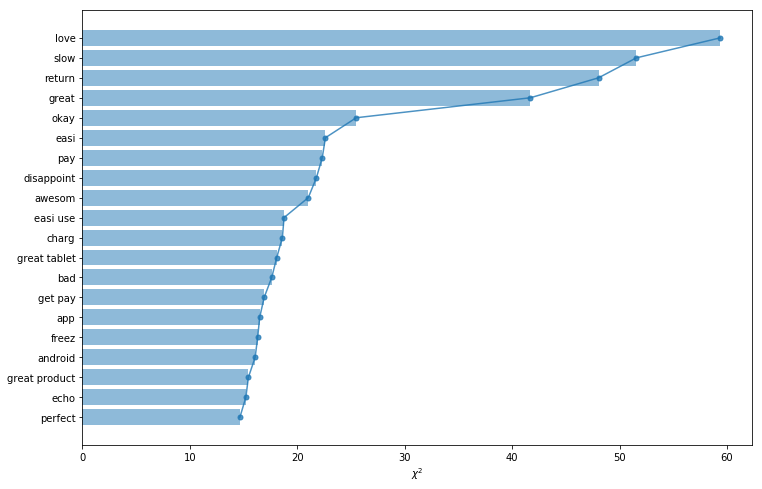

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12,8))
scores = list(zip(tfidf.get_feature_names(), chi2score))
chi2 = sorted(scores, key=lambda x:x[1])
topchi2 = list(zip(*chi2[-20:]))
x = range(len(topchi2[1]))
labels = topchi2[0]
plt.barh(x,topchi2[1], align='center', alpha=0.5)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels)
plt.xlabel('$\chi^2$')
plt.show();

In [34]:
chi_rank = {k:v for k, v in zip(topchi2[0],topchi2[1])}

In [36]:
def get_chi_rank_per_text(text):
    total_score = 0
    for word in text:
        if word in chi_rank:
            total_score += chi_rank[word]
    return total_score

df['cmt_rank'] = df['comment_clean'].apply(get_chi_rank_per_text)
df['topic_rank'] = df['topics'].apply(get_chi_rank_per_text)

# Add word2vec as a factor

In [37]:
# let X be a list of tokenized texts (i.e. list of lists of tokens)
model = Word2Vec(df.comment_clean, size=50)
w2v_trained = dict(zip(model.wv.index2word, model.wv.vectors))

In [38]:
class EmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec

    def transform(self, X):
        return X.apply(self.line_to_vec)
    
    def line_to_vec(self, line):
        row = []
        for w in line:
            if w not in self.word2vec:
                row+=[0]
            else:
                row+=[np.mean(self.word2vec[w])]
        return row    

In [39]:
embedding = EmbeddingVectorizer(w2v_trained)
df['cmt_w2v'] = embedding.transform(df['comment_clean'])
df['topic_w2v'] = embedding.transform(df['topics'])

In [40]:
df['cmt_w2v_mean'] = df['cmt_w2v'].apply(np.mean)
df['topic_w2v_mean'] = df['topic_w2v'].apply(np.mean)

# Add doc2vec as a factor

In [41]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from sklearn import utils
from gensim.models.doc2vec import TaggedDocument

In [42]:
def label_sentences(corpus, label_type):
    """
    Gensim's Doc2Vec implementation requires each document/paragraph to have a label associated with it.
    We do this by using the TaggedDocument method. The format will be "TRAIN_i" or "TEST_i" where "i" is
    a dummy index of the post.
    """
    labeled = []
    for i, v in enumerate(corpus):
        label = label_type + '_' + str(i)
        labeled.append(TaggedDocument(v, [label]))
    return labeled

In [43]:
doc2vec_cmt = label_sentences(df.comment_clean, 'Comment')
doc2vec_topic = label_sentences(df.topics, 'Topic')
doc2vec_all_data = doc2vec_cmt + doc2vec_topic

In [44]:
model_dbow = Doc2Vec(dm=0, vector_size=50, negative=5, min_count=1, alpha=0.065, min_alpha=0.065)
model_dbow.build_vocab([x for x in tqdm(doc2vec_all_data)])

100%|██████████| 15016/15016 [00:00<00:00, 2349185.71it/s]


In [45]:
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(doc2vec_all_data)]), total_examples=len(doc2vec_all_data), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 15016/15016 [00:00<00:00, 2499272.57it/s]


In [46]:
def get_vectors(model, corpus_size, vectors_size, vectors_type):
    """
    Get vectors from trained doc2vec model
    :param doc2vec_model: Trained Doc2Vec model
    :param corpus_size: Size of the data
    :param vectors_size: Size of the embedding vectors
    :param vectors_type: Training or Testing vectors
    :return: list of vectors
    """
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = model.docvecs[prefix]
    return vectors

In [47]:
df_topic_d2v = pd.DataFrame(get_vectors(model_dbow, len(df.topics), 50, 'Topic')).add_prefix('d2v_tpc')
df_cmt_d2v = pd.DataFrame(get_vectors(model_dbow, len(df.comment_clean), 50, 'Comment')).add_prefix('d2v_cmt')

In [80]:
df = df.reset_index(drop=True)
df_full = pd.concat([df, df_topic_d2v, df_cmt_d2v], axis=1)

In [82]:
df_full.shape

(7508, 130)

In [83]:
df_full.head()

,id,name,categories,manufacturer,reviews.date,reviews.dateSeen,reviews.doRecommend,reviews.numHelpful,reviews.rating,reviews.text,...,d2v_cmt40,d2v_cmt41,d2v_cmt42,d2v_cmt43,d2v_cmt44,d2v_cmt45,d2v_cmt46,d2v_cmt47,d2v_cmt48,d2v_cmt49
0,AVqVGZNvQMlgsOJE6eUY,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...","Computers,Electronics Features,Tablets,Electro...",Amazon,2017-09-03T00:00:00.000Z,"2018-05-27T00:00:00Z,2017-09-18T00:00:00Z,2017...",0.0,0.0,3.0,I thought it would be as big as small paper bu...,...,0.406725,0.490591,0.592947,0.086458,-0.216621,-0.880753,0.324097,0.840732,0.369070,0.105539
1,AVqVGZNvQMlgsOJE6eUY,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...","Computers,Electronics Features,Tablets,Electro...",Amazon,2017-06-06T00:00:00.000Z,"2018-05-27T00:00:00Z,2017-07-07T00:00:00Z,2017...",1.0,0.0,5.0,This kindle is light and easy to use especiall...,...,-0.207001,0.182017,0.119846,-0.233603,0.084920,0.089752,-0.378652,0.207999,-0.269092,0.137328
2,AVqVGZNvQMlgsOJE6eUY,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...","Computers,Electronics Features,Tablets,Electro...",Amazon,2018-04-20T00:00:00.000Z,2018-05-27T00:00:00Z,1.0,0.0,4.0,Didnt know how much i'd use a kindle so went f...,...,0.180312,0.443598,0.286322,-0.731421,-0.306343,0.091049,-0.637082,0.005416,0.185822,0.004425
3,AVqVGZNvQMlgsOJE6eUY,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...","Computers,Electronics Features,Tablets,Electro...",Amazon,2017-11-02T17:33:31.000Z,2018-10-09T00:00:00Z,1.0,3.0,5.0,I am 100 happy with my purchase. I caught it o...,...,0.606253,-0.095045,0.004898,-0.589268,-0.082918,-0.612602,-0.071745,0.229055,0.751302,0.569672
4,AVqVGZNvQMlgsOJE6eUY,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...","Computers,Electronics Features,Tablets,Electro...",Amazon,2018-04-24T00:00:00.000Z,2018-05-27T00:00:00Z,1.0,0.0,5.0,Solid entry level Kindle. Great for kids. Gift...,...,-0.489695,0.313294,1.088919,-0.376338,0.021660,-0.073599,0.265098,0.548052,-0.685218,-0.300222


In [88]:
columns1 = [
     'bulk',
     'senti_score',
     'cmt_rank',
     'topic_rank',
     'cmt_w2v_mean',
     'topic_w2v_mean',
    'strong_bad_senti'
]
columns2 = [col for col in df_full.columns if col.startswith('d2v')]
cols = columns1 + columns2
X = df_full[cols]
y = df_full['reviews.doRecommend']

In [90]:
X.shape

(7508, 107)

# Apply manual ranking

In [115]:
rank_matrix = [1]*X.shape[1]

In [116]:
# weightages are given to cols of 'senti_score','cmt_rank','topic_rank','strong_bad_senti'
rank_matrix[1],rank_matrix[2],rank_matrix[3],rank_matrix[6] = 5, 2, 2,10

In [130]:
rank_matrix = pd.Series(rank_matrix).ravel()

In [133]:
rank_matrix.shape

(107,)

In [136]:
def apply_ranking(row):
    return row*(rank_matrix)

X = X.apply(apply_ranking, axis=1)

# Fit table with ML models

In [137]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [138]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [53]:
def train_evaluate(estimator, X_train, y_train, X_test, y_test):
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)
    
    return (accuracy_score(y_test, y_pred), confusion_matrix(y_test, y_pred))

In [140]:
lgr = LogisticRegression()
rf = RandomForestClassifier()
gnb = GaussianNB()
svm = SVC()

for estimator in [lgr, rf, gnb, svm]:
    print(train_evaluate(estimator, X_train, y_train, X_test, y_test))
    print('_'*50)

/anaconda3/envs/nlp_venv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/nlp_venv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


(0.8559322033898306, array([[ 334,  214],
       [ 143, 1787]]))
__________________________________________________
(0.844632768361582, array([[ 315,  233],
       [ 152, 1778]]))
__________________________________________________
(0.811541565778854, array([[ 396,  152],
       [ 315, 1615]]))
__________________________________________________
(0.8720742534301856, array([[ 348,  200],
       [ 117, 1813]]))
__________________________________________________


## SVM model gives the highest performance (accuracy 87.2%), followed by Logistic Regression model (accuracy 85.6%). Since Gridsearch on SVM is quite slow, here I'll grid search on Logistic Regression model.

In [145]:
param_range = np.logspace(-3,3,7)
param_grid = [{'penalty': ['l1', 'l2'], 'C': param_range, 'solver': ['liblinear', 'saga']},
          {'penalty': ['l2'], 'C': param_range, 'solver': ['newton-cg','sag', 'lbfgs']}]

grid2 = GridSearchCV(lgr, param_grid, scoring='accuracy', n_jobs=-1, verbose=2, cv=3)

In [141]:
grid2.fit(X_train, y_train)

Fitting 3 folds for each of 49 candidates, totalling 147 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 147 out of 147 | elapsed:    8.6s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'penalty': ['l1', 'l2'], 'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]), 'solver': ['liblinear', 'saga']}, {'penalty': ['l2'], 'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]), 'solver': ['newton-cg', 'sag', 'lbfgs']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=2)

In [142]:
y_pred = grid2.best_estimator_.predict(X_test)
print('accuracy: ',accuracy_score(y_test, y_pred))
print('conf matrix: \n',confusion_matrix(y_test, y_pred))

accuracy:  0.8559322033898306
conf matrix: 
 [[ 322  226]
 [ 131 1799]]


### The best Logistic Regression model after gridsearch gives an accuracy of <font color='red'>85.6% </font>
### The best SVM model gives an accuracy of <font color='red'>87.2% </font>